In [341]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

%matplotlib inline

#To display all outputs in a cell rather than the last output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
DF = pd.merge(study_results, mouse_metadata, how='left', on='Mouse ID')

In [342]:
# Checking the number of mice in the DataFrame.
DF['Mouse ID'].value_counts().count()

249

In [343]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
# Note:- As per the description, for a timepoint, there should be only one entry for any mouse


#Duplicate Mice
duplicate_mice_ids = list(DF[DF.duplicated(subset=['Mouse ID','Timepoint'], keep = False)]['Mouse ID'].unique())
duplicate_mice_ids

['g989']

In [344]:
# Optional: Get all the data for the duplicate mouse ID. 

#Extra:- Duplicated Entries are displayed as follows:
#DF[DF.duplicated(subset=['Mouse ID','Timepoint'], keep = False)]

DF[DF['Mouse ID'].isin(duplicate_mice_ids)]
#13 rows for this mouse

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
107,g989,0,45.000000,0,Propriva,Female,21,26
137,g989,0,45.000000,0,Propriva,Female,21,26
329,g989,5,48.786801,0,Propriva,Female,21,26
360,g989,5,47.570392,0,Propriva,Female,21,26
620,g989,10,51.745156,0,Propriva,Female,21,26
681,g989,10,49.880528,0,Propriva,Female,21,26
815,g989,15,51.325852,1,Propriva,Female,21,26
869,g989,15,53.442020,0,Propriva,Female,21,26
950,g989,20,55.326122,1,Propriva,Female,21,26
1111,g989,20,54.657650,1,Propriva,Female,21,26


In [345]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
# Note:- All data corresponding to this mouse is dropped

DF.drop(DF[DF['Mouse ID'].isin(duplicate_mice_ids)].index, axis=0, inplace=True)
#Left with 1880 rows

In [346]:
# Checking the number of mice in the clean DataFrame.
DF['Mouse ID'].value_counts().count()

248

## Summary Statistics

In [347]:
######################################PLEASE READ THIS######################################
#1. Though we are taking a complete data set, it has to be considered as sample NOT population. Reason being, 248 mice represents entire population of mice here to derive the study results
#2. Because of 1, variance formula should be that of sample variance (ddof = 1, losing 1 degree  of freedom as sample mean is derived from the same data)
#3. Because of 1, std deviation formula should be that of sample std deviation (ddof = 1, losing 1 degree  of freedom as sample mean is derived from the same data)
#4. Most importantly, because of 1, SEM is not a relevant statistics here. SEM is the std. error of mean. It is tied to CLT (Central Limit Theorem), which says, the sample mean of "truly" randomly \
####picked ensembles converge to the population mean with std error of mean (SEM) = population std /sqrt(of ensemble size). This is used to derive population std deviation from samples.
####Means, if we know SEM, then std.deviation = SEM*ensemble size. 
####The scipy implementation of SEM is std_dev/sqrt(size of array) is not useful for us. I am using SEM(ddof =1) here, just to match up with std calculation. But, rightfully, we shouldn't take SEM here.

In [348]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# This method is the most straightforward, creating multiple series and putting them all together at the end.

#Create a group based on 'Drug Regimen'
drug_regimen_grp = DF.groupby('Drug Regimen')
mean = drug_regimen_grp['Tumor Volume (mm3)'].mean()
median = drug_regimen_grp['Tumor Volume (mm3)'].median()
variance = drug_regimen_grp['Tumor Volume (mm3)'].var(ddof=1)
std_dev = drug_regimen_grp['Tumor Volume (mm3)'].std(ddof=1)
sem = drug_regimen_grp['Tumor Volume (mm3)'].apply(lambda x: st.sem(x, ddof=1))

#Combine everything to a DF
summary_stats_method1 = pd.concat([mean, median, variance, std_dev, sem], axis=1)
summary_stats_method1.columns = ['mean', 'median', 'variance', 'std_dev', 'sem']
summary_stats_method1

,mean,median,variance,std_dev,sem
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [349]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# This method produces everything in a single groupby function.


#Create a group based on 'Drug Regimen'
drug_regimen_grp = DF.groupby('Drug Regimen')
#Aggregate based on the summary stats
summary_stats_method2 = drug_regimen_grp.aggregate(mean=('Tumor Volume (mm3)', 'mean'), median=('Tumor Volume (mm3)', 'median'), variance=('Tumor Volume (mm3)', lambda x:np.var(x, ddof=1)), std_dev = ('Tumor Volume (mm3)', lambda x:np.std(x, ddof=1)), sem = (('Tumor Volume (mm3)', lambda x: st.sem(x, ddof=1))))                  
summary_stats_method2



,mean,median,variance,std_dev,sem
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar Plots

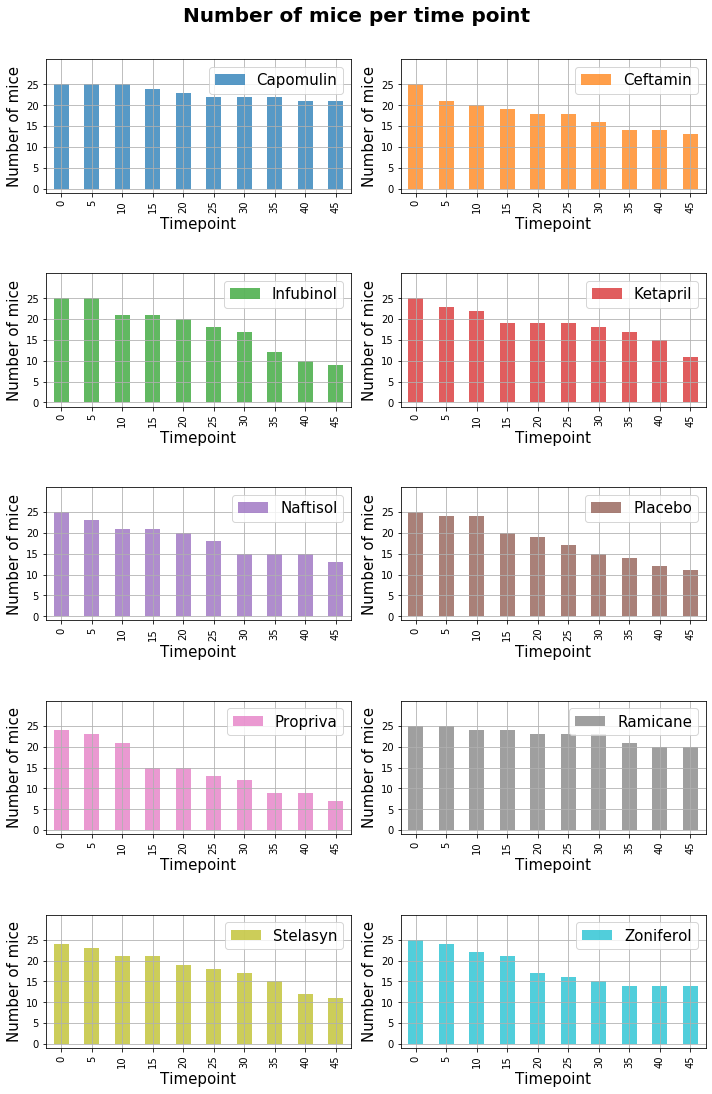

In [355]:
# Generate a bar plot showing the number of mice per time point for each treatment throughout the course of the study using pandas.    

#Group DF with 'Drug Regimen' and 'Timepoint'
#Convert the 'Timepoint' index as columns
Timepoint_Regime_Mice_Number = DF.groupby(['Timepoint', 'Drug Regimen'])['Mouse ID'].count()
TS_Regime_Mice_Number = Timepoint_Regime_Mice_Number.unstack(level=-1, fill_value=0) #By default level=-1

axes = TS_Regime_Mice_Number.plot(
                           width=0.5,
                           kind = 'bar',
                           figsize=(10,15),
                           subplots='True',
                           layout=(len(TS_Regime_Mice_Number.columns)//2, 2), #(5,2)
                           grid=True,
                           legend='False', #To get better control on legends
     
                           sharex=False, sharey=False,
                           
                           yticks=np.arange(0, TS_Regime_Mice_Number.max(axis=1).max(axis=0)+1, 5),
                           xlim=(TS_Regime_Mice_Number.index.to_list()[0]-1, TS_Regime_Mice_Number.index.to_list()[-1]+1),
                           ylim=(-1, TS_Regime_Mice_Number.max(axis=1).max(axis=0)+6),
                           alpha=0.75,
                           
                           )      
#Beautification !!!
_=plt.suptitle('Number of mice per time point', fontsize=20, weight='bold', y=1.01)
axes = axes.reshape(TS_Regime_Mice_Number.columns.shape)
_=[ax.legend(loc='upper right',fontsize = 15) for ax in axes]
_=[ax.set_ylabel('Number of mice',fontsize = 15) for ax in axes]
_=[ax.set_xlabel('Timepoint',fontsize = 15) for ax in axes]
_=[ax.set_title("\n") for ax in axes]
_ = plt.tight_layout()

_= plt.savefig('../Images/graph1.png', bbox_inches = "tight" )
plt.show()

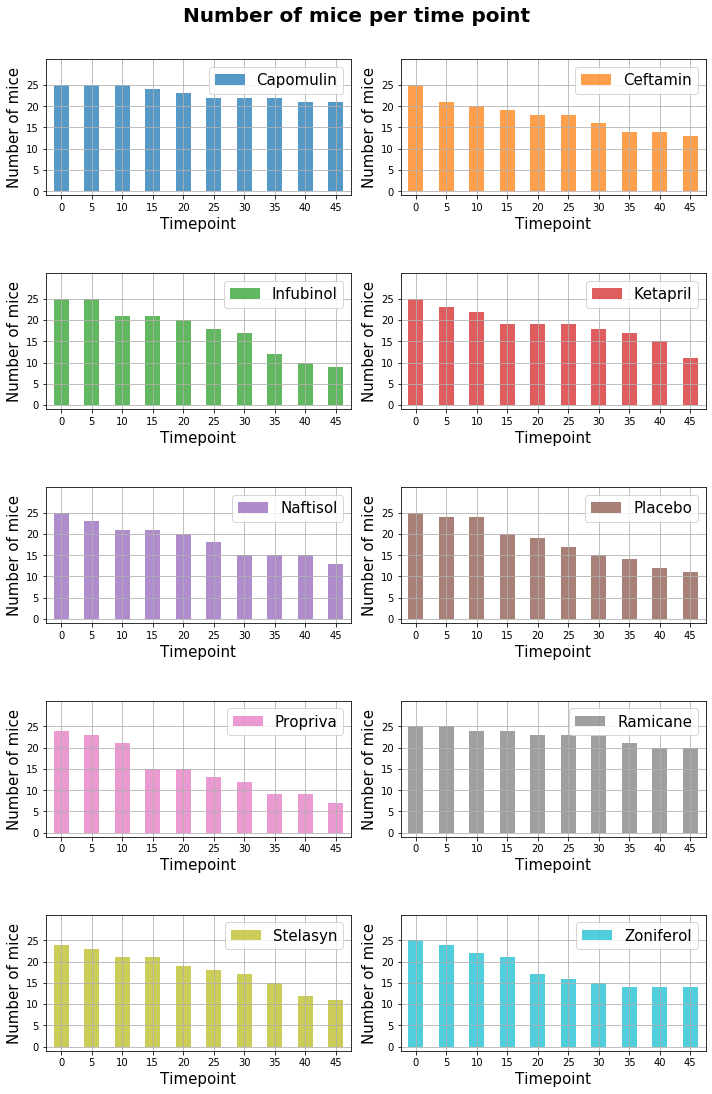

In [352]:
# Generate a bar plot showing the number of mice per time point for each treatment throughout the course of the study using pyplot.

#Group DF with 'Drug Regimen' and 'Timepoint'
#Convert the 'Timepoint' index as columns
Timepoint_Regime_Mice_Number = DF.groupby(['Timepoint', 'Drug Regimen'])['Mouse ID'].count()
TS_Regime_Mice_Number = Timepoint_Regime_Mice_Number.unstack(level=-1, fill_value=0) #By default level=-1
#TS_Regime_Mice_Number

#Generate subplot layout
fig, axes = plt.subplots(len(TS_Regime_Mice_Number.columns)//2, 2, sharex=False, sharey=False, figsize=(10, 15))
#Flatten the axes array
axes = axes.ravel() #Same as axes.reshape(TS_Regime_Mice_Number.columns.shape)
#Take the default color cycler
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
#Plot in loop
for index, col in enumerate(TS_Regime_Mice_Number.columns):
    _=axes[index].bar(x = TS_Regime_Mice_Number.index.to_list(), height= TS_Regime_Mice_Number[col].to_list(), color=colors[index], alpha=0.75, label=col, width=2.5)                
    #xticks, yticks
    _=axes[index].set_xticks(TS_Regime_Mice_Number.index.to_list()) 
    _=axes[index].set_xticklabels(TS_Regime_Mice_Number.index.to_list())
    _=axes[index].set_yticks(np.arange(0, TS_Regime_Mice_Number.max(axis=1).max(axis=0)+1, 5))
    _=axes[index].set_yticklabels(np.arange(0, TS_Regime_Mice_Number.max(axis=1).max(axis=0)+1, 5))
    #xlim, ylim
    _=axes[index].set_xlim(TS_Regime_Mice_Number.index.to_list()[0]-2.5, TS_Regime_Mice_Number.index.to_list()[-1]+2.5)
    _=axes[index].set_ylim(-1, TS_Regime_Mice_Number.max(axis=1).max(axis=0)+6)
    #xlabel, ylabel
    _=axes[index].set_xlabel('Timepoint',fontsize = 15)
    _=axes[index].set_ylabel('Number of mice',fontsize = 15)
    #legend
    _=axes[index].legend(loc='upper right', fontsize = 15)
    #title of individual subplots as a blank line
    _=axes[index].set_title("\n")
    #grid on
    _=axes[index].grid()

_=plt.suptitle('Number of mice per time point', fontsize=20, weight='bold', y=1.01)    
_ = plt.tight_layout()
plt.show()



## Pie Plots

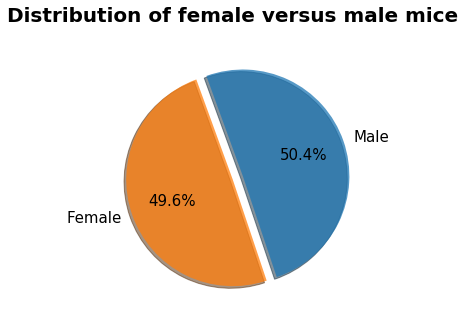

In [498]:
# Generate a pie plot showing the distribution of female versus male mice using pandas

#Group DF with 'Mouse ID' and extract the 'Sex' and take value counts

DF_gender = DF.groupby(['Mouse ID'])['Sex'].first().value_counts()
explode = [(0.1 if gender==DF_gender.idxmax(axis=0) else 0)for gender in DF_gender.index]#Only make the max explode
axes = DF_gender.plot(kind='pie', label='', startangle=110, autopct='%1.1f%%', counterclock=False, explode=explode, shadow=True, colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(DF_gender)], wedgeprops={'alpha':0.75}, fontsize=15)                  
axes.set_aspect("equal")

_=plt.suptitle('Distribution of female versus male mice', fontsize=20, weight='bold', y=1.1)    
_ = plt.tight_layout()
plt.show()


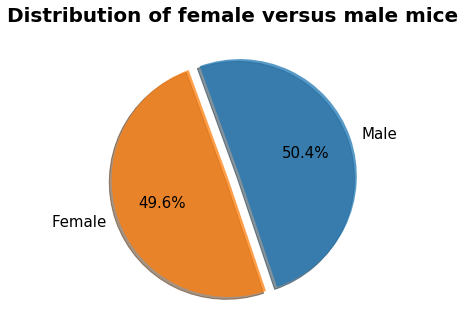

In [502]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot

#Group DF with 'Mouse ID' and extract the 'Sex' and take value counts

DF_gender = DF.groupby(['Mouse ID'])['Sex'].first().value_counts()
explode = [(0.1 if gender==DF_gender.idxmax(axis=0) else 0)for gender in DF_gender.index]#Only make the max explode

fig, ax = plt.subplots()
_ = ax.pie(DF_gender, labels=DF_gender.index, startangle=110, autopct='%1.1f%%', counterclock=False, explode=explode, shadow=True, colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(DF_gender)], wedgeprops={'alpha':0.75}, textprops={'fontsize': 15})   
_=ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


_=plt.suptitle('Distribution of female versus male mice', fontsize=20, weight='bold', y=1.1)    
_ = plt.tight_layout()


_= plt.savefig('../Images/graph2.png', bbox_inches = "tight" )
plt.show()



In [ ]:
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct="%.1f%%", shadow=True, startangle=0, rotatelabels=True)
plt.axis("equal")

In [488]:
texts

[Text(1.1327396616418983, 0.3961071306394242, 'Male'),
 Text(-1.0383446898384068, -0.36309820308613894, 'Female')]

In [467]:
[(0.1 if gender==DF_gender.idxmax(axis=0) else 0)for gender in DF_gender.index]

[0.1, 0]

In [427]:
axes